In [1]:
# Test migration history reconstruction on simulated data

import sys
import os

REPO_DIR = os.path.join(os.getcwd(), "../../../")
from metient.metient import *
import metient.lib.vertex_labeling as vert
import metient.util.vertex_labeling_util as vutil
import metient.util.data_extraction_util as dutil

import matplotlib
import torch
MACHINA_DATA_DIR = os.path.join(REPO_DIR, 'metient/data/machina_sims')
OUT_DIR = os.path.join(REPO_DIR, "metient/test/output_plots")

CUDA GPU: False


In [2]:
import pydot
from IPython.display import Image, display

def visualize_ground_truth(tree_fn, graph_fn):
    def view_pydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)
    
    (graph,) = pydot.graph_from_dot_file(tree_fn)
    view_pydot(graph)

    (graph,) = pydot.graph_from_dot_file(graph_fn)
    view_pydot(graph)
        

Ground truth


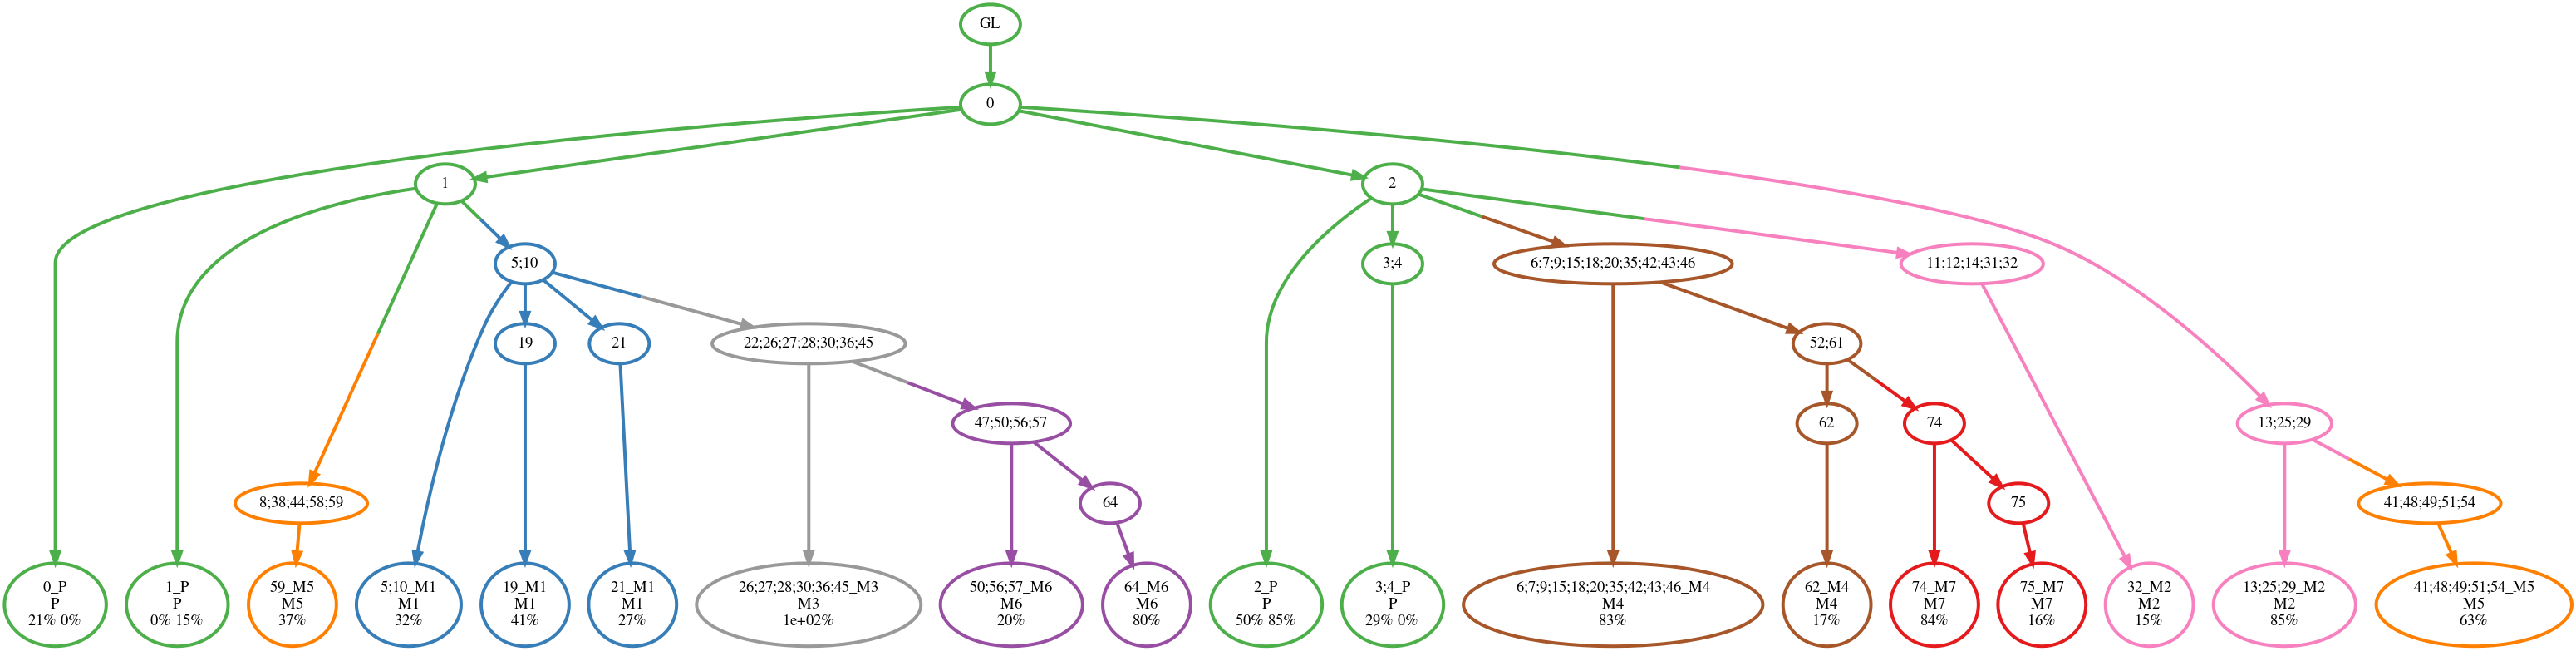

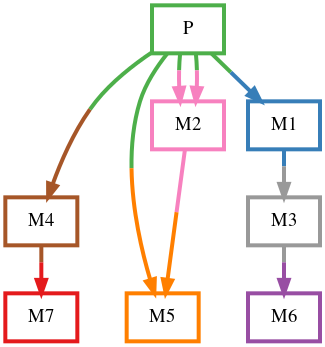

In [3]:
num_sites = "m8"
mig_type = "M"
seed = 19

og_sims_dir = "/data/morrisq/divyak/projects/machina/data/sims"
SIM_DATA_DIR = os.path.join(og_sims_dir, num_sites, mig_type)
print("Ground truth")
visualize_ground_truth(os.path.join(SIM_DATA_DIR, f"T_seed{seed}.dot"), os.path.join(SIM_DATA_DIR, f"G_seed{seed}.dot"))




In [4]:
import fnmatch
custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'cornflowerblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
def find_labelings_all_mutation_trees(site, cluster_fn, all_mut_trees_fn, ref_var_fn):
    weights = Weights(mig=0.563*50, comig=0.246*50, seed_site=0.197*50,gen_dist=0.1, reg=0.5, data_fit=15.0)
    
    trees = fnmatch.filter(os.listdir(os.path.join(MACHINA_DATA_DIR, f"{site}_clustered_input_corrected")), f"cluster_{mig_type}_seed{seed}_tree*.tsv")

    idx_to_cluster_label = dutil.get_idx_to_cluster_label(cluster_fn)
    data = dutil.get_adj_matrices_from_spruce_mutation_trees(all_mut_trees_fn, idx_to_cluster_label, is_sim_data=True)
    custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'royalblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
    perf_stats = []
    trees = [trees[0]]

    print("Number of trees:", len(trees))
    for tree_num in range(len(trees)):

        ref_var_fn = os.path.join(MACHINA_DATA_DIR, f"{site}_clustered_input_corrected", f"cluster_{mig_type}_seed{seed}_tree{tree_num}.tsv")
        data = dutil.get_adj_matrices_from_spruce_mutation_trees(all_mut_trees_fn, idx_to_cluster_label, is_sim_data=True)
        T = torch.tensor(data[tree_num][0], dtype = torch.float32)
        print(T.shape)
        print_config = PrintConfig(visualize=True, verbose=False, k_best_trees=10, save_outputs=True)
#         vert.evaluate(T, ref_var_fn, weights, print_config, "../output_plots/", f"tree{tree_num}_seed{seed}", 
#                       None, batch_size=1024, custom_colors=custom_colors, bias_weights=True, solve_polytomies=True)
        vert.calibrate([T], [ref_var_fn], print_config, "../output_plots/", [f"tree{tree_num}_seed{seed}"], 
                      None, batch_size=1024, custom_colors=custom_colors, bias_weights=True, solve_polytomies=True)

        

Number of trees: 1
torch.Size([16, 16])
Saving results to ../output_plots/calibrate
Overwriting existing directory at ../output_plots/calibrate

*** Calibrating for patient: tree0_seed19 ***
ordered_sites ['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']


  0%|          | 0/166 [00:00<?, ?it/s]

updating path


  1%|          | 1/166 [00:02<07:33,  2.75s/it]

using cached path


  1%|          | 2/166 [00:04<06:19,  2.31s/it]

using cached path


  2%|▏         | 3/166 [00:05<05:31,  2.04s/it]

using cached path


  2%|▏         | 4/166 [00:06<04:52,  1.80s/it]

using cached path


  3%|▎         | 5/166 [00:07<04:24,  1.64s/it]

using cached path


  4%|▎         | 6/166 [00:09<04:04,  1.53s/it]

using cached path


  4%|▍         | 7/166 [00:10<03:51,  1.46s/it]

using cached path


  5%|▍         | 8/166 [00:11<03:40,  1.40s/it]

using cached path


  5%|▌         | 9/166 [00:13<03:34,  1.37s/it]

using cached path


  6%|▌         | 10/166 [00:14<03:28,  1.33s/it]

using cached path


  7%|▋         | 11/166 [00:15<03:23,  1.31s/it]

using cached path


  7%|▋         | 12/166 [00:16<03:21,  1.31s/it]

using cached path


 11%|█         | 18/166 [00:17<02:04,  1.19it/s]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 16%|█▌        | 26/166 [00:18<01:00,  2.31it/s]

updating path
updating path
updating path
updating path


 17%|█▋        | 29/166 [00:18<00:43,  3.11it/s]

updating path
updating path
updating path
updating path


 20%|██        | 34/166 [00:18<00:24,  5.36it/s]

updating path
updating path
updating path
updating path


 23%|██▎       | 38/166 [00:23<01:16,  1.67it/s]

updating path
updating path
updating path
updating path


 25%|██▌       | 42/166 [00:23<00:40,  3.09it/s]

updating path
updating path
updating path
updating path


 30%|██▉       | 49/166 [00:23<00:20,  5.62it/s]

updating path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 36%|███▌      | 59/166 [00:24<00:10, 10.07it/s]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 39%|███▊      | 64/166 [00:24<00:07, 13.11it/s]

using cached path
using cached path
using cached path
using cached path
using cached path


/lila/data/morrisq/divyak/projects/metient/metient/lib/vertex_labeling.py:710: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  known_labelings.append(torch.eye(num_sites)[optimal_site].T)
 44%|████▍     | 73/166 [00:25<00:11,  7.81it/s]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 50%|█████     | 83/166 [00:26<00:06, 13.57it/s]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 56%|█████▌    | 93/166 [00:26<00:03, 21.29it/s]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 59%|█████▉    | 98/166 [00:26<00:02, 25.44it/s]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 62%|██████▏   | 103/166 [00:33<00:29,  2.12it/s]

using cached path
using cached path
using cached path
using cached path


 64%|██████▍   | 107/166 [00:40<00:48,  1.21it/s]

using cached path
using cached path
using cached path


 66%|██████▋   | 110/166 [00:44<00:57,  1.02s/it]

using cached path
using cached path


 67%|██████▋   | 112/166 [00:47<01:02,  1.15s/it]

using cached path
using cached path


 69%|██████▊   | 114/166 [00:50<01:05,  1.26s/it]

using cached path


 69%|██████▉   | 115/166 [00:52<01:08,  1.34s/it]

using cached path


 70%|██████▉   | 116/166 [00:54<01:10,  1.42s/it]

using cached path


 70%|███████   | 117/166 [00:55<01:10,  1.44s/it]

using cached path


 71%|███████   | 118/166 [00:57<01:10,  1.48s/it]

using cached path


 72%|███████▏  | 119/166 [00:58<01:08,  1.45s/it]

using cached path


 72%|███████▏  | 120/166 [01:00<01:09,  1.50s/it]

using cached path


 73%|███████▎  | 121/166 [01:01<01:09,  1.54s/it]

using cached path


 73%|███████▎  | 122/166 [01:03<01:09,  1.58s/it]

using cached path


 74%|███████▍  | 123/166 [01:04<01:05,  1.52s/it]

using cached path


 75%|███████▍  | 124/166 [01:06<01:02,  1.48s/it]

using cached path


 75%|███████▌  | 125/166 [01:07<01:00,  1.47s/it]

using cached path


 76%|███████▌  | 126/166 [01:09<01:00,  1.52s/it]

using cached path


 77%|███████▋  | 127/166 [01:10<01:01,  1.57s/it]

using cached path


 77%|███████▋  | 128/166 [01:12<01:01,  1.61s/it]

using cached path


 78%|███████▊  | 129/166 [01:14<00:58,  1.57s/it]

using cached path


 81%|████████▏ | 135/166 [01:15<00:31,  1.00s/it]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 87%|████████▋ | 145/166 [01:15<00:10,  2.00it/s]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


 93%|█████████▎| 155/166 [01:15<00:02,  3.90it/s]

using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
using cached path


100%|██████████| 166/166 [01:15<00:00,  2.19it/s]


using cached path
using cached path
using cached path
using cached path
using cached path
using cached path
unique solutions 1321
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
up

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updati

pareto_metrics {(10, 8, 5), (10, 9, 4), (11, 7, 1)}
# final solutions: 7
updating path
updating path
updating path
updating path
updating path
updating path
updating path
Calibrating to 1 patients
Optimized thetas: tensor([0.68, 0.26, 0.06], grad_fn=<DivBackward0>)
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
updating path
tree0_seed19_P
10 unique trees were not found (7 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

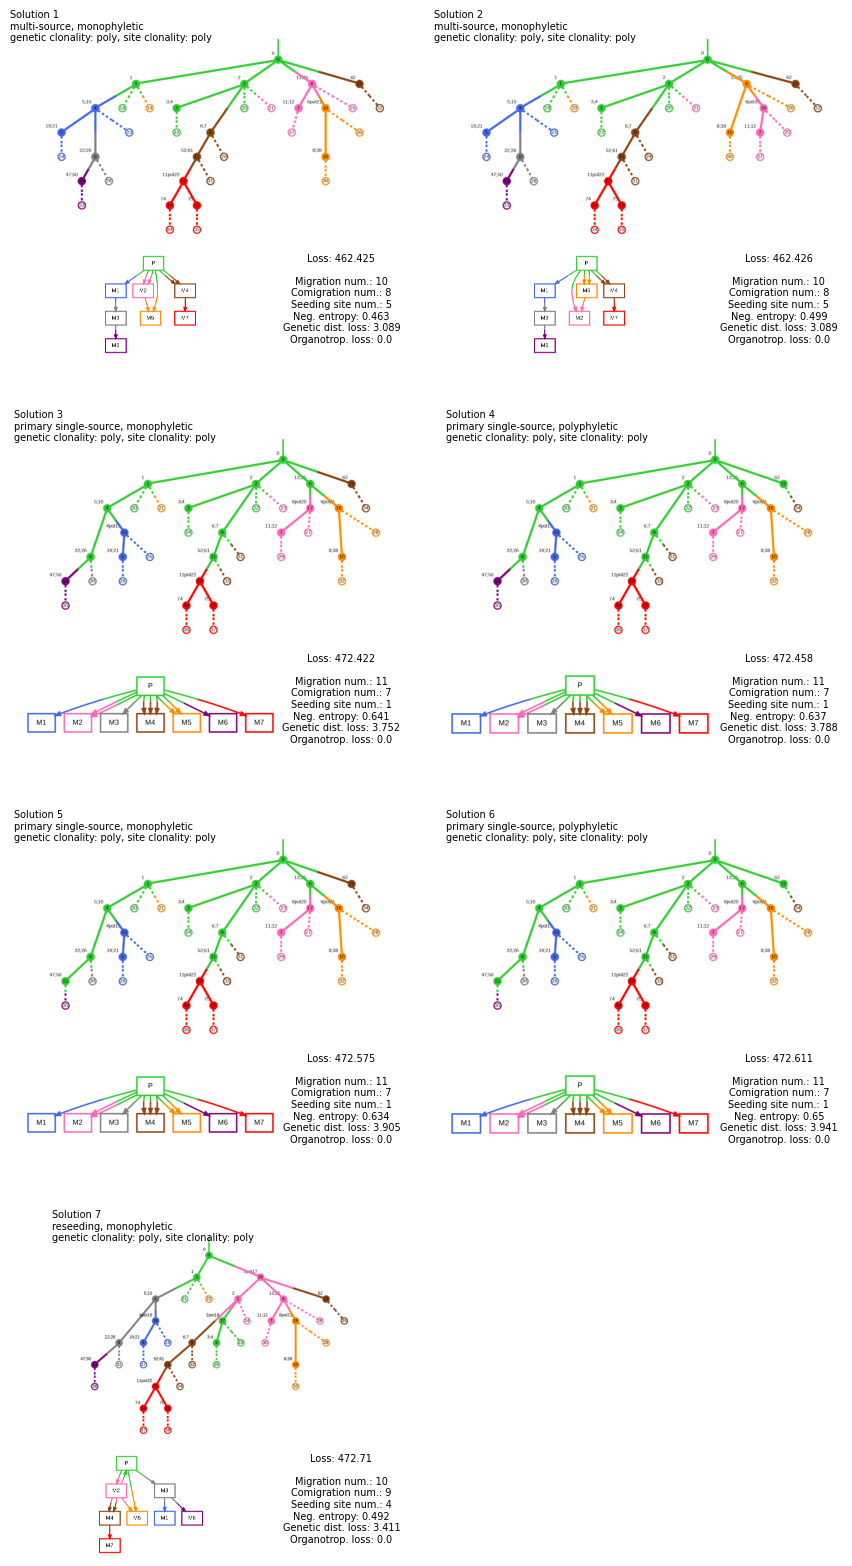

In [ ]:
%%prun
find_labelings_all_mutation_trees(num_sites, os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{seed}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{seed}.tsv"))

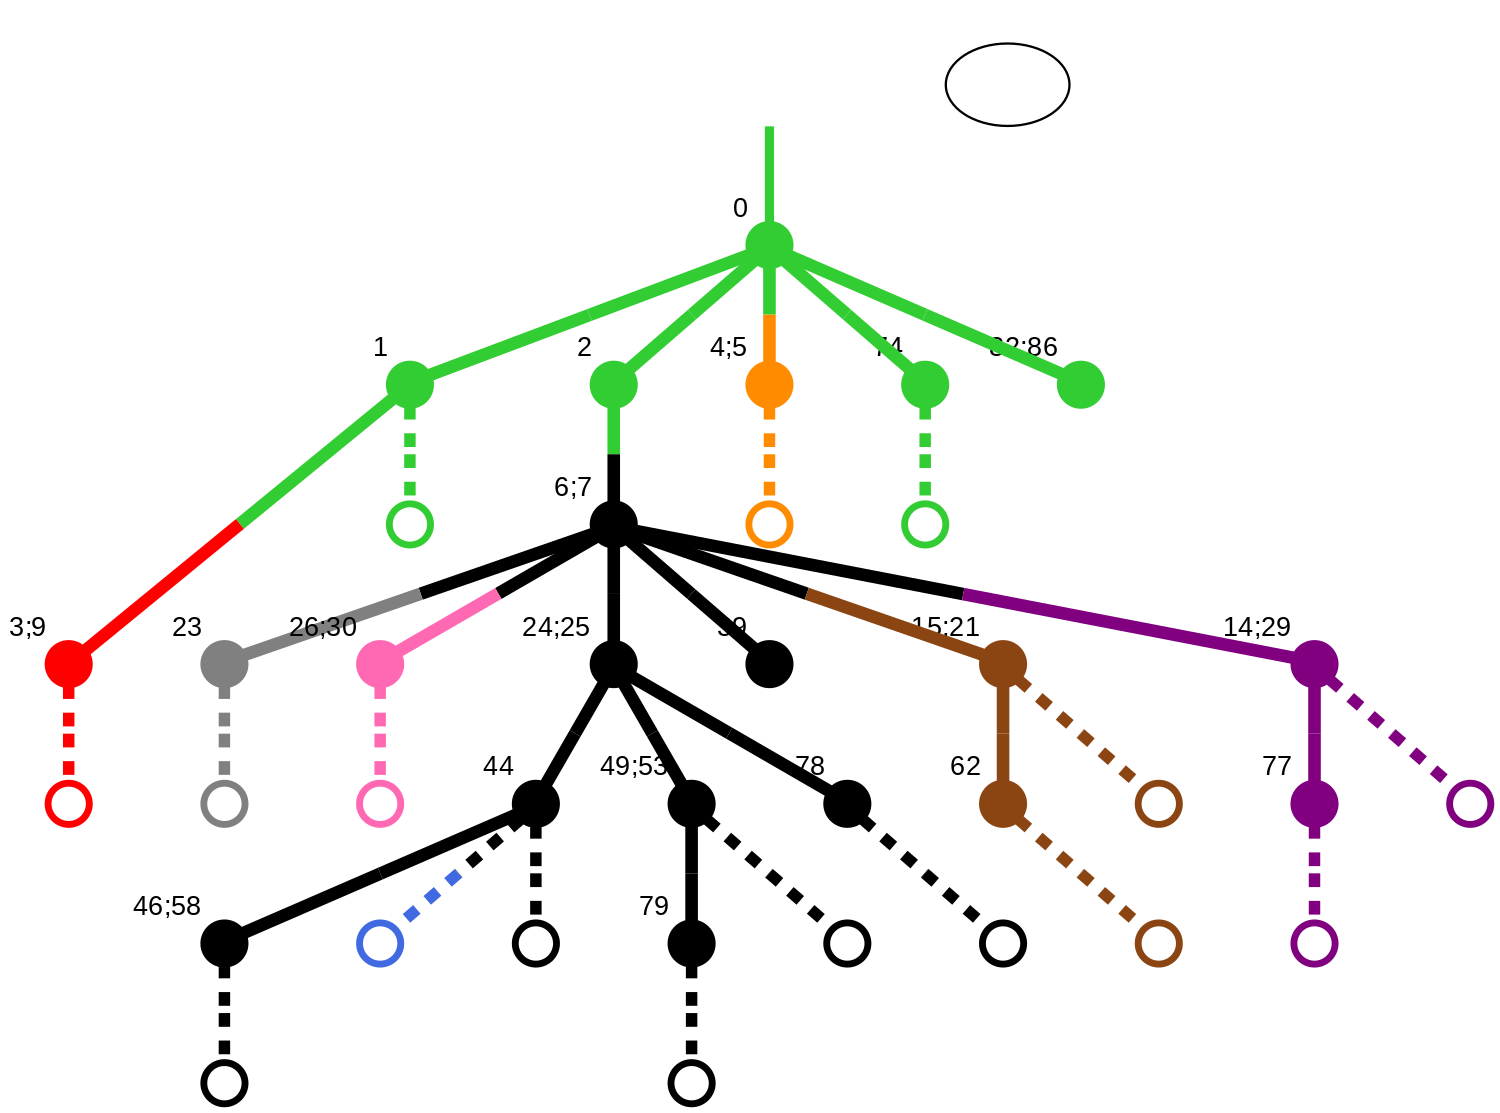

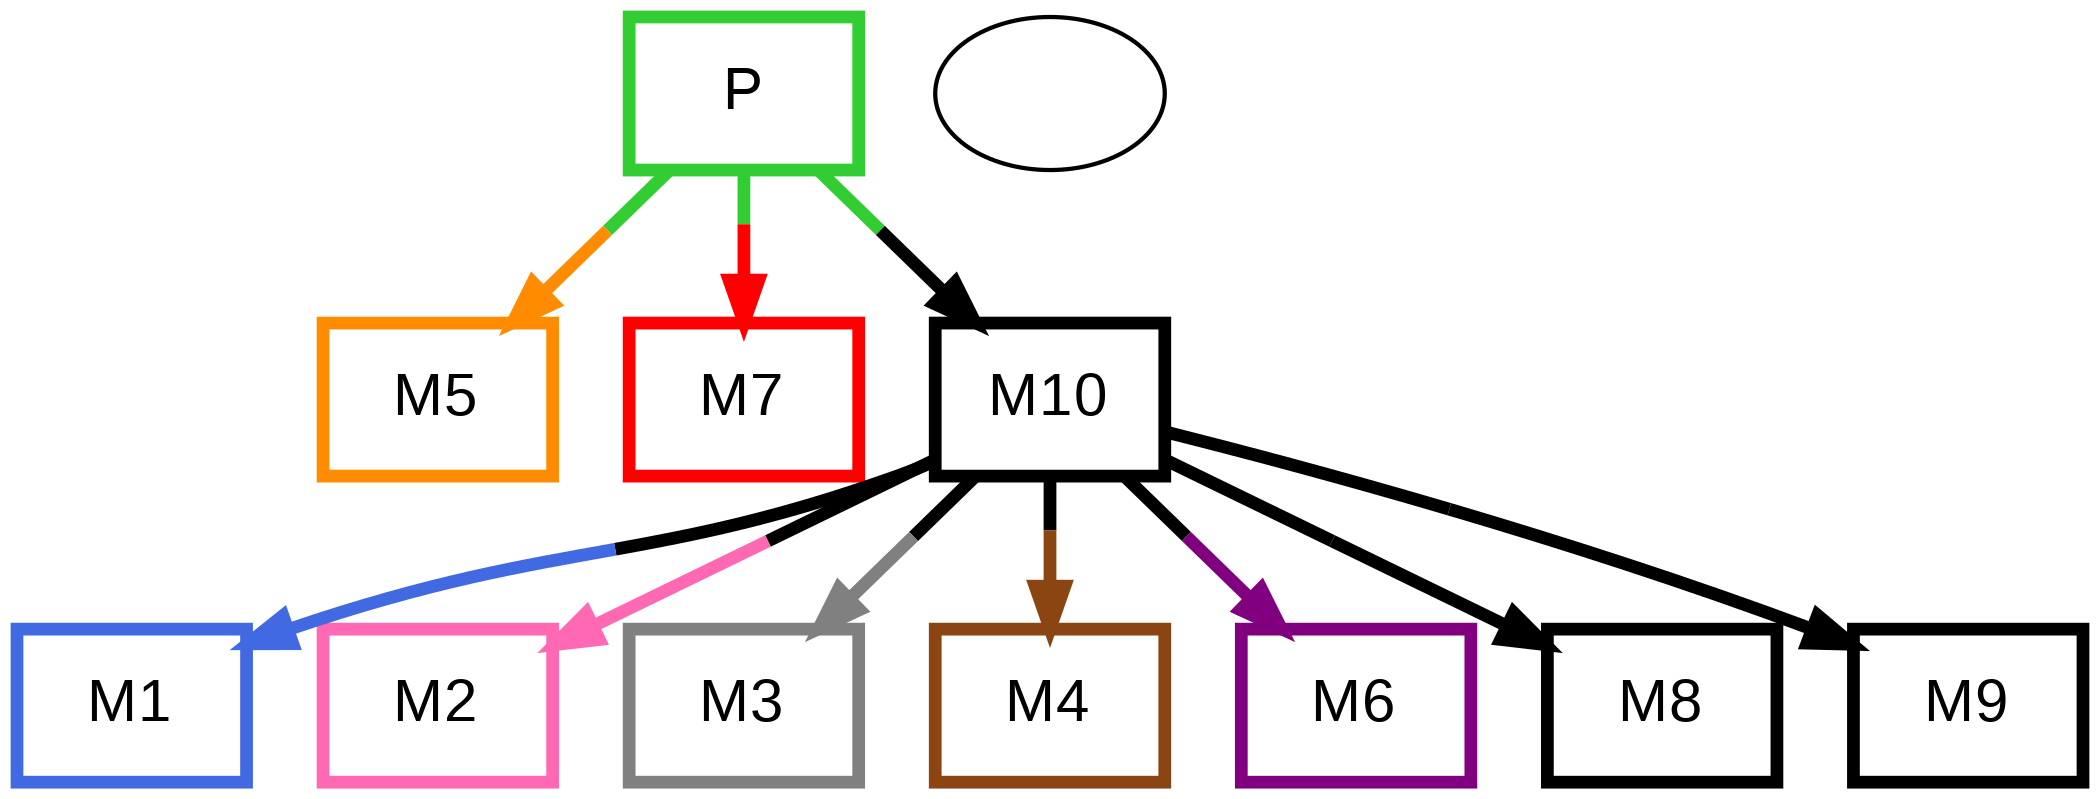

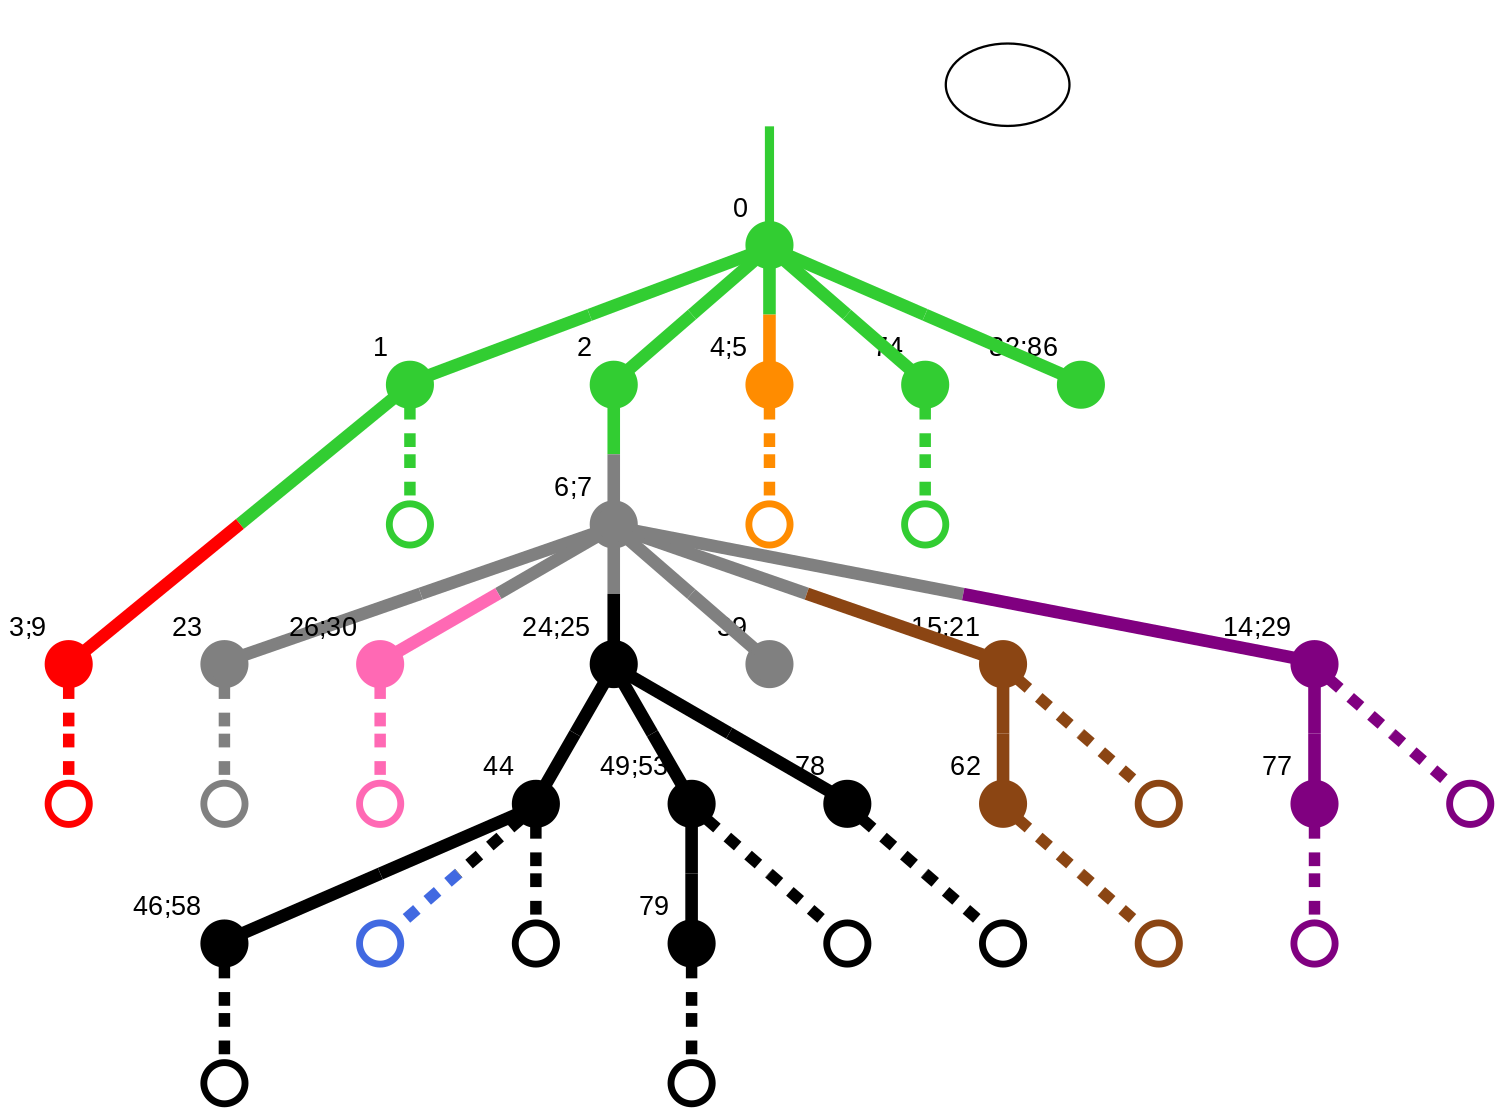

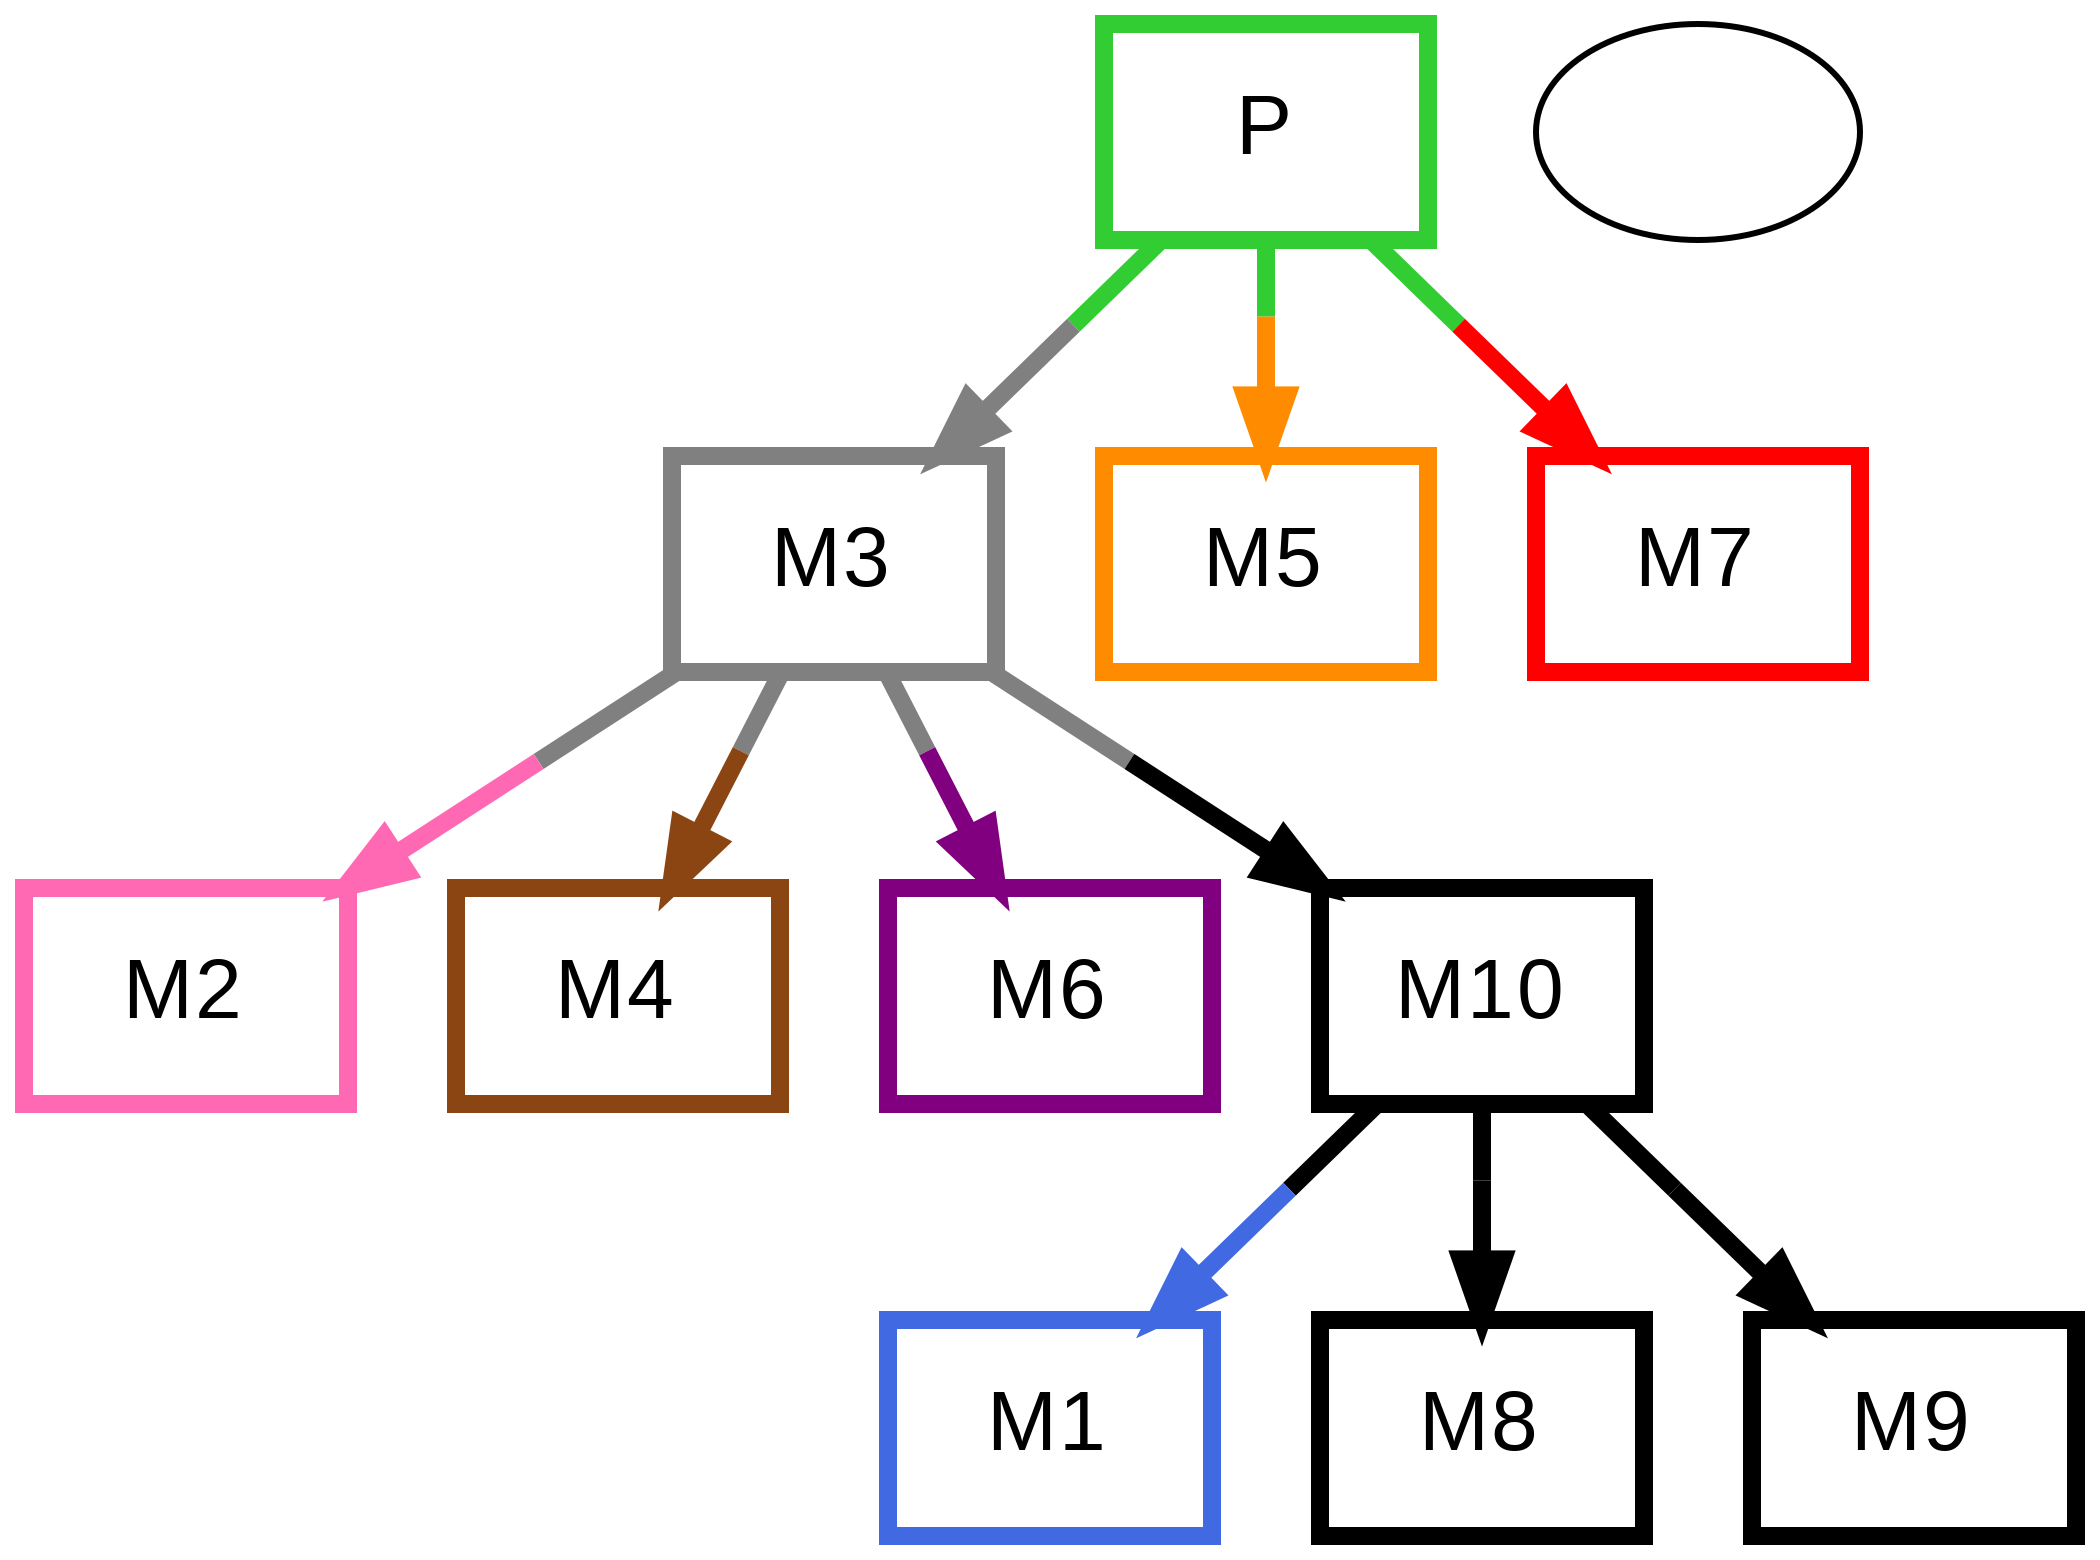

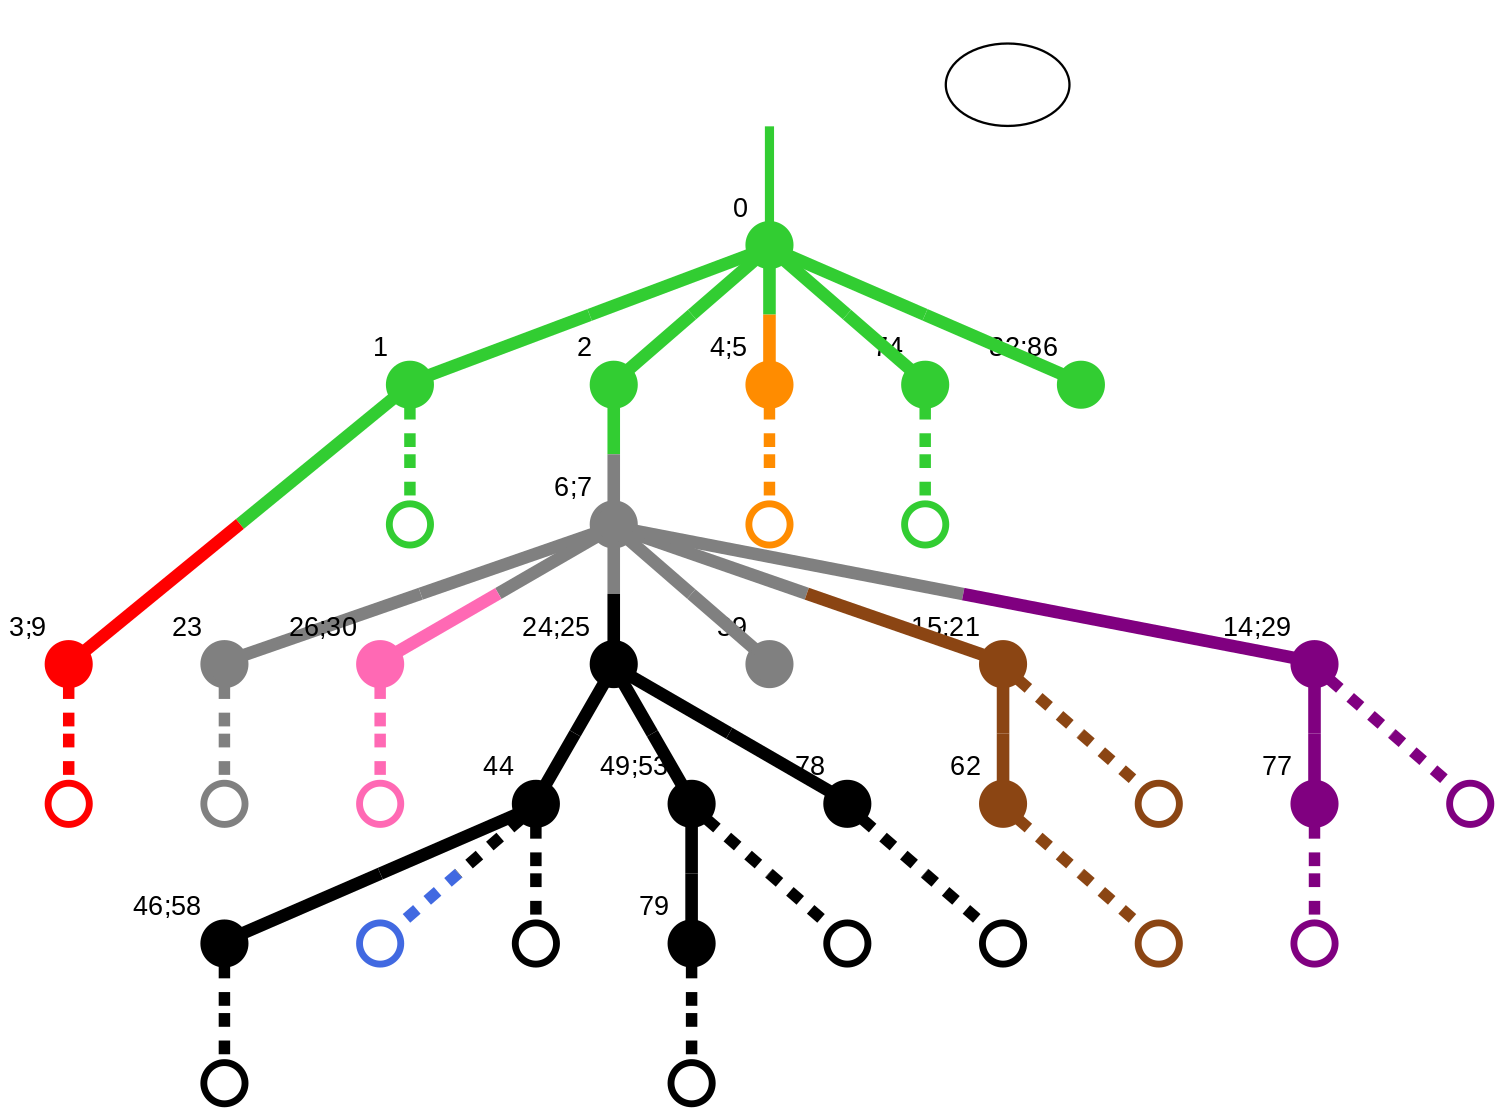

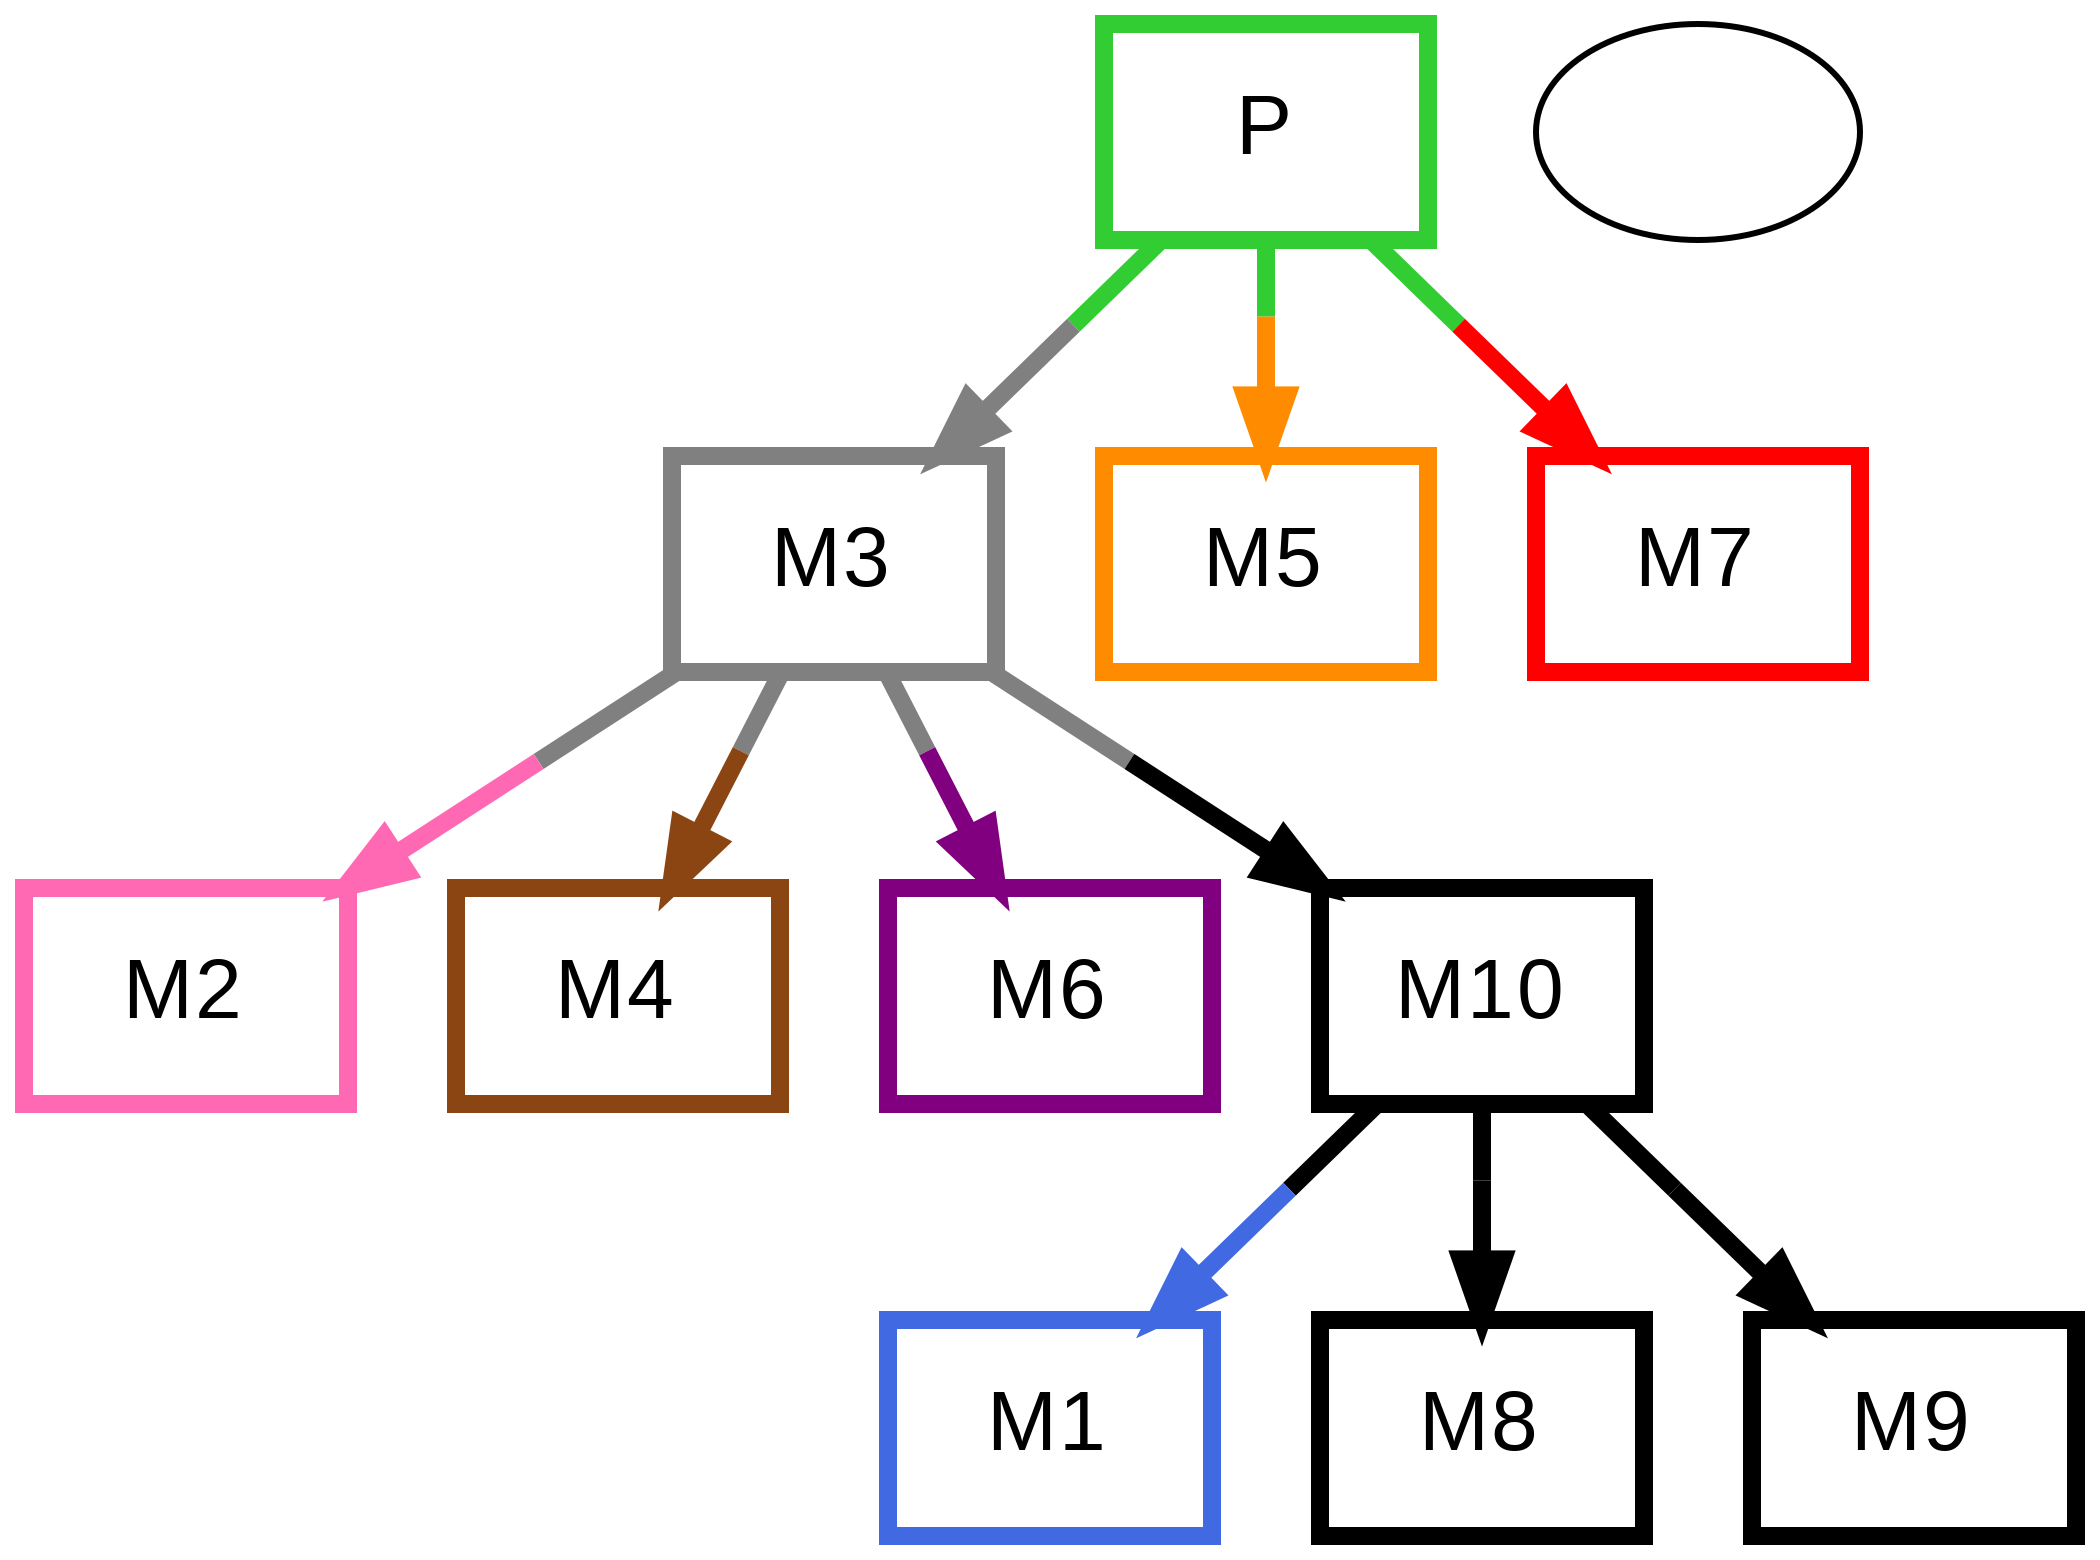

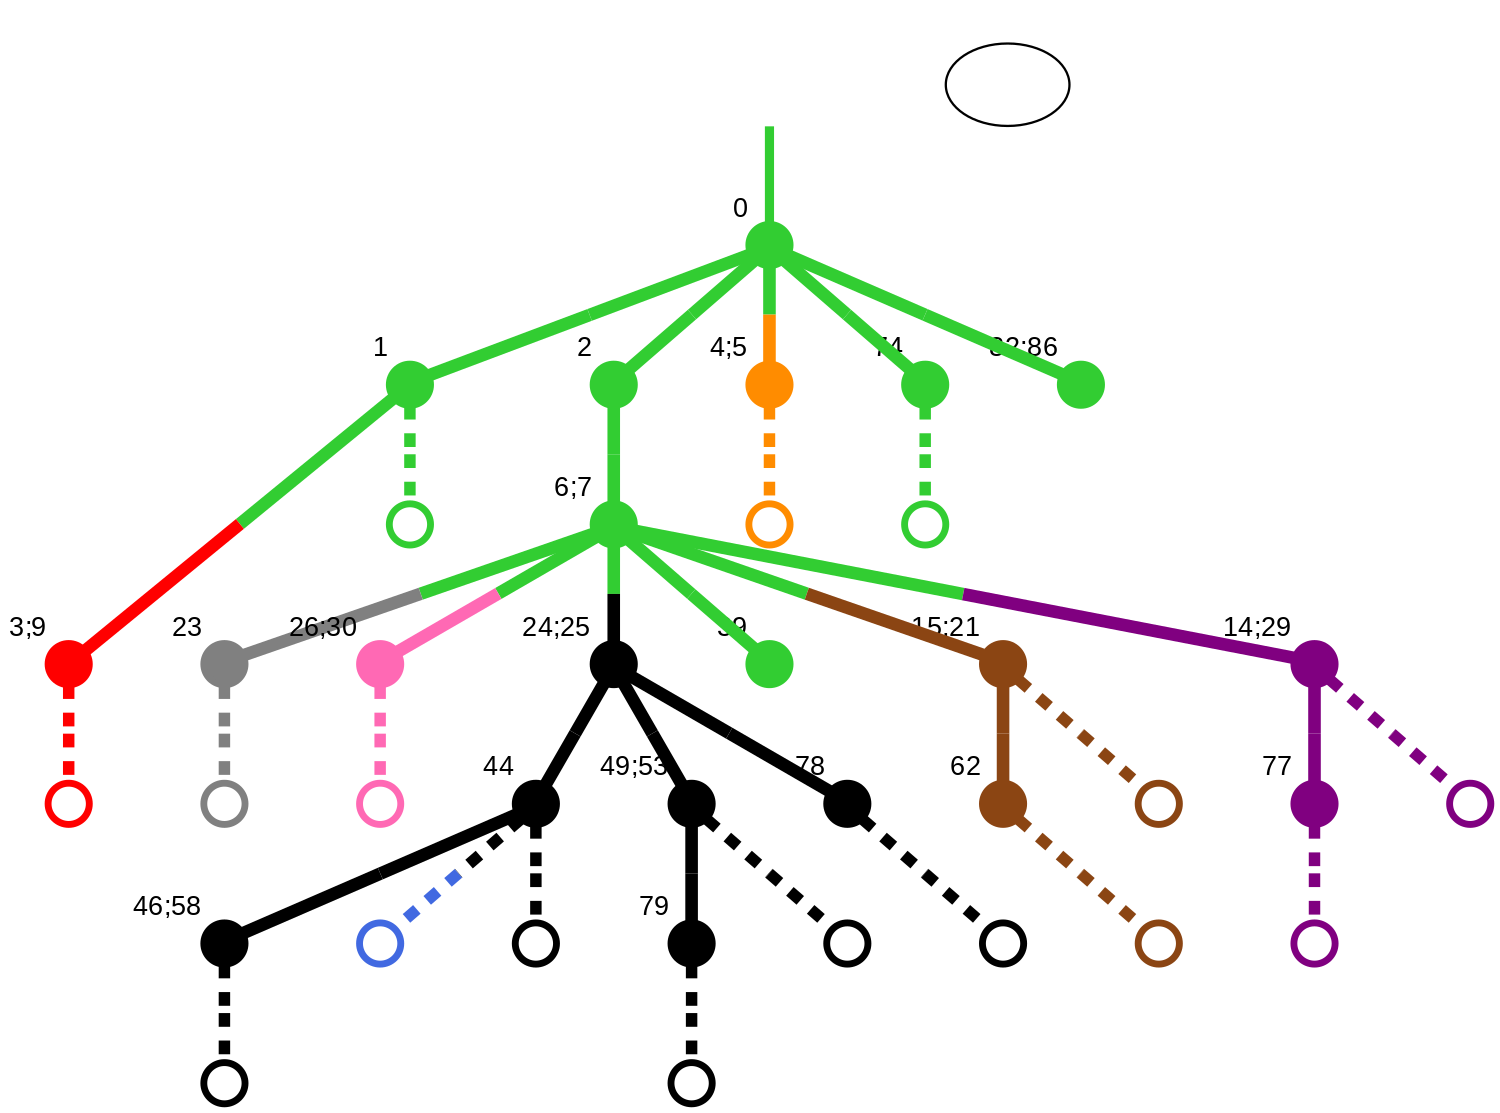

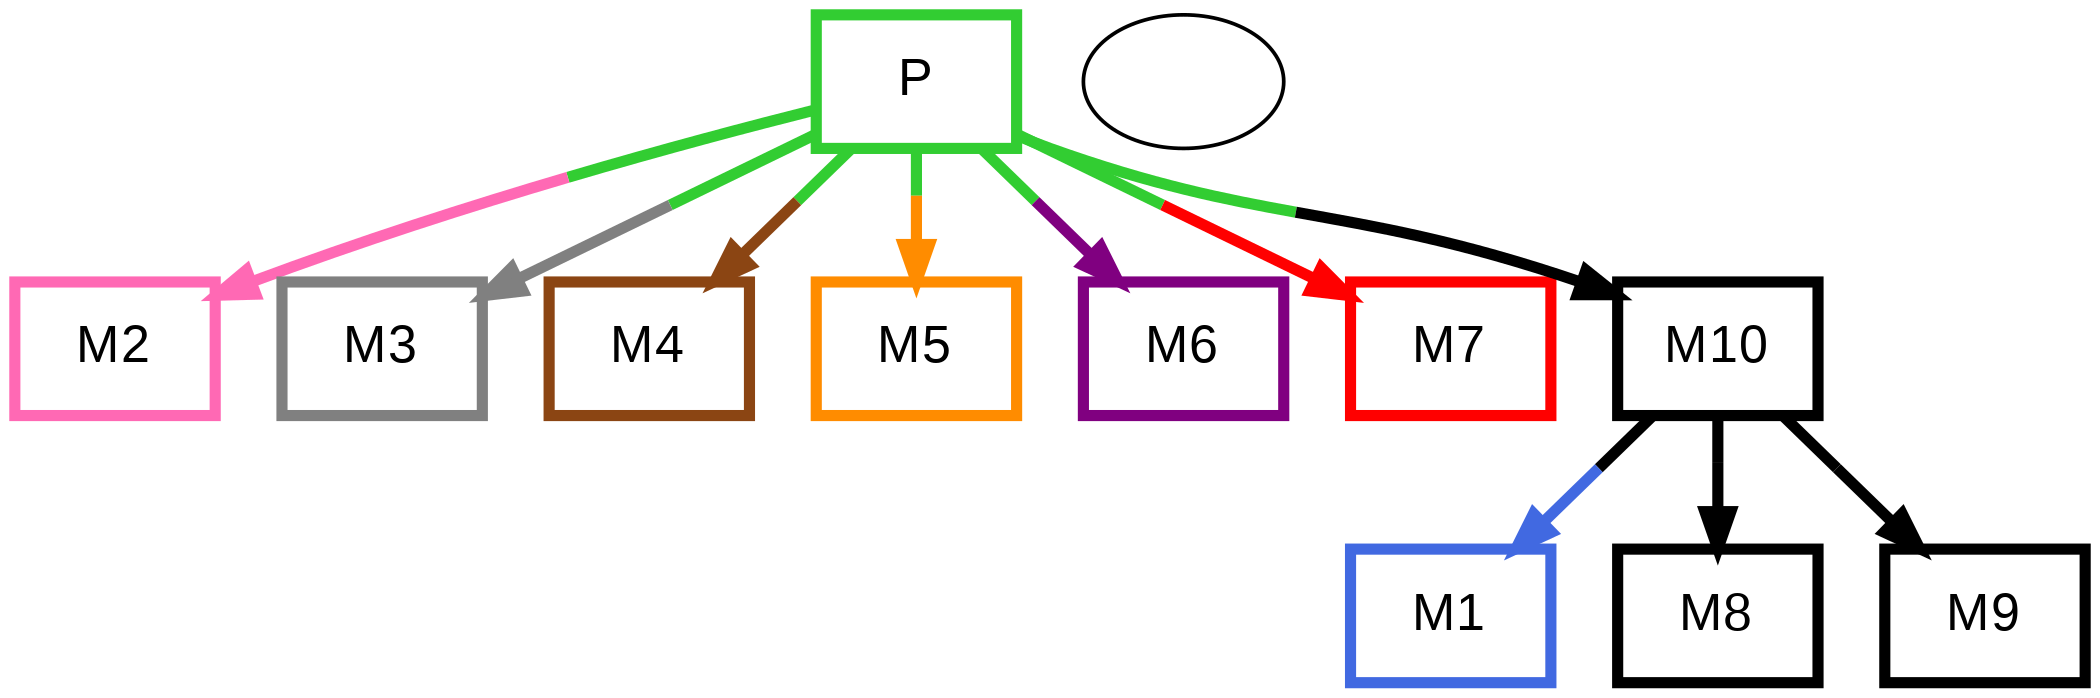

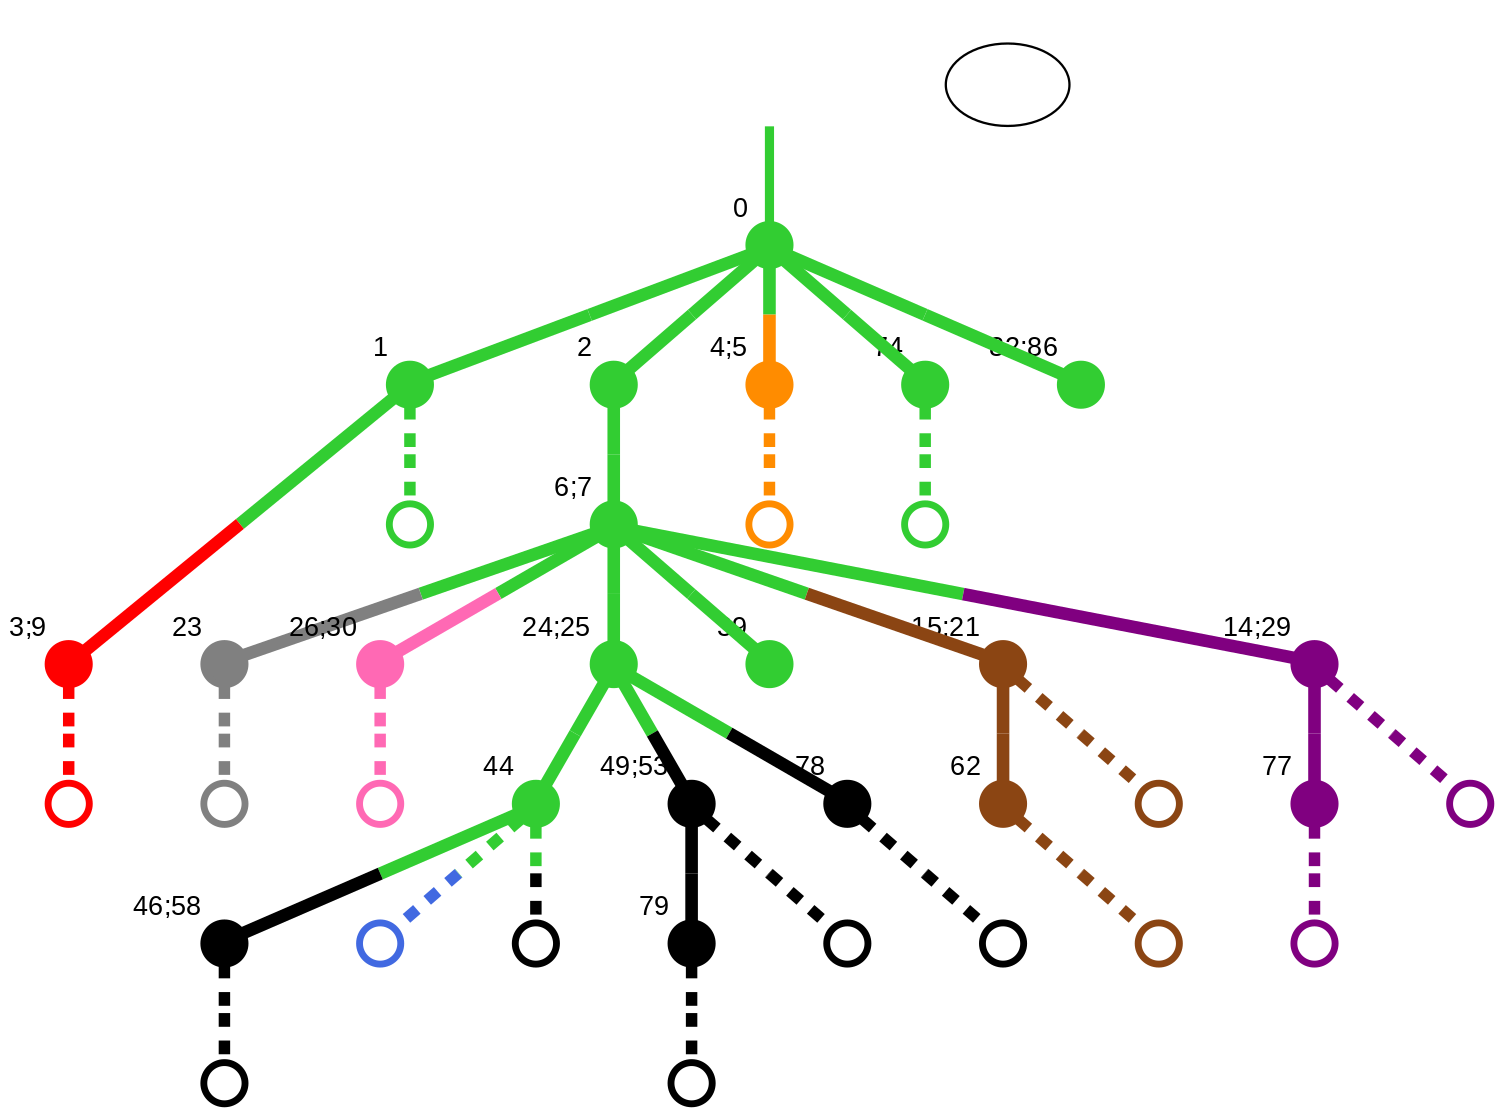

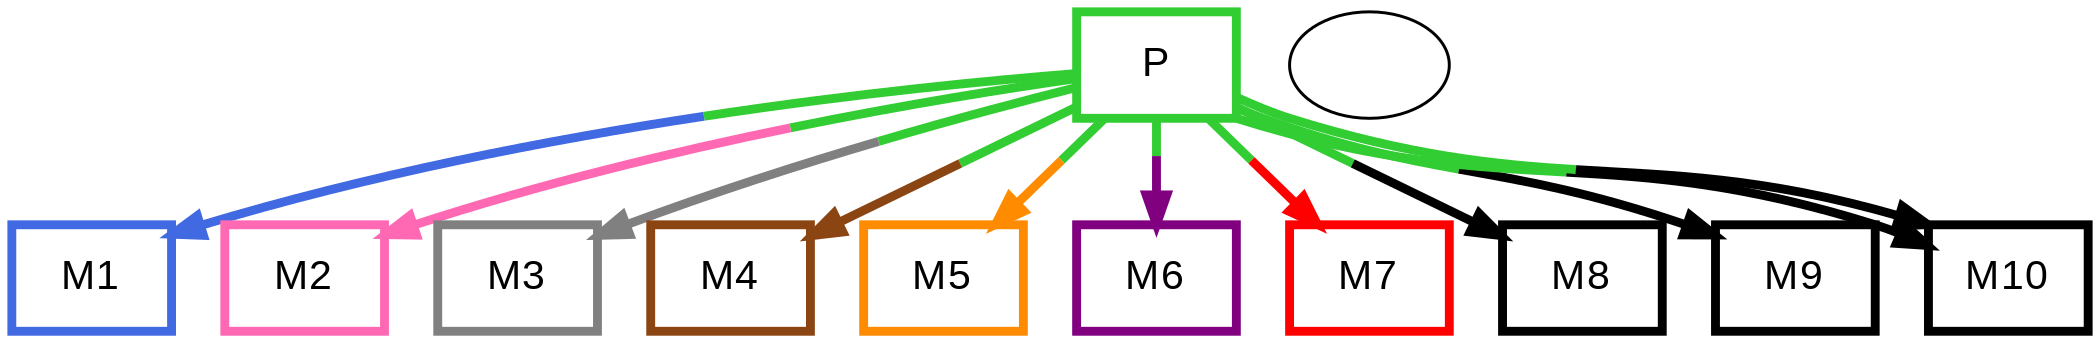

In [18]:
f = '/data/morrisq/divyak/data/metient_prediction_results/'

tree = 0

for run in range(5):
    base_fn = os.path.join(f, f"predictions_batch_exp_bs1024_calibrate_wip_fixedinit_lessreg_r{run+1}_06072024", num_sites, mig_type)
    visualize_ground_truth(os.path.join(base_fn, f"tree{tree}_seed{seed}_calibrate.tree.dot"), os.path.join(base_fn, f"tree{tree}_seed{seed}_calibrate.mig_graph.dot"))
